In [141]:
# Load modules
# system level
import os
import numpy as np
import pandas as pd
import time
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

# machine learning
import tensorflow as tf
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Graphics in retina format are more sharp and legible
%config InlineBackend.figure_format = 'retina'
import matplotlib
%matplotlib inline

### Load data

In [2]:
def to_tensor(arg):
    arg = tf.convert_to_tensor(arg)
    return arg

In [142]:
# Load year 1 train, test, validation image files
x_Y1_train = to_tensor('images_Y1_test.npy')
x_Y1_test = to_tensor('images_Y1_train.npy')
x_Y1_valid = to_tensor('images_Y1_valid.npy')

In [4]:
# Load year 10 train, test, validation image files
x_Y10_train = to_tensor('images_Y10_test.npy')
x_Y10_test = to_tensor('images_Y10_test.npy')
x_Y10_valid = to_tensor('images_Y10_valid.npy')

In [5]:
# Load image label files
y_label_train = np.load('labels_train.npy')
y_label_test = np.load('labels_test.npy')
y_label_valid = np.load('labels_valid.npy')

In [74]:
label_train_df = pd.DataFrame(y_label_train)
label_test_df = pd.DataFrame(y_label_test)
label_valid_df = pd.DataFrame(y_label_valid)

### EDA

In [75]:
#label_train_df.info()
#label_test_df.info()
#label_valid_df.info()

In [76]:
#label_train_df.describe()
#label_test_df.describe()
#label_valid_df.describe()

In [77]:
#label_train_df.memory_usage()
#label_test_df.memory_usage()
#label_valid_df.memory_usage()

In [78]:
#label_train_df.value_counts()
#label_test_df.value_counts()
#label_valid_df.value_counts()

In [128]:
data = label_train_df.set_axis(['Spiral', 'Elliptical', 'Merger'], axis=1, inplace=False)

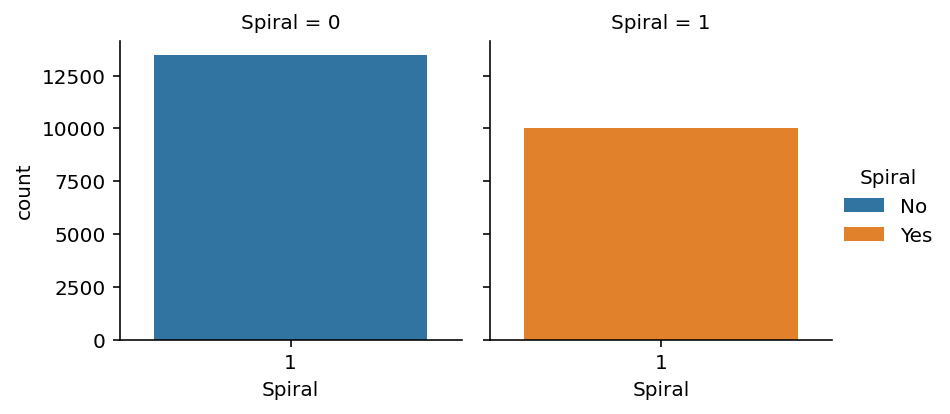

In [143]:
g = sns.FacetGrid(data, col="Spiral", hue="Spiral")
g.map(sns.countplot, "Spiral")
g.add_legend(labels=["No", "Yes"])

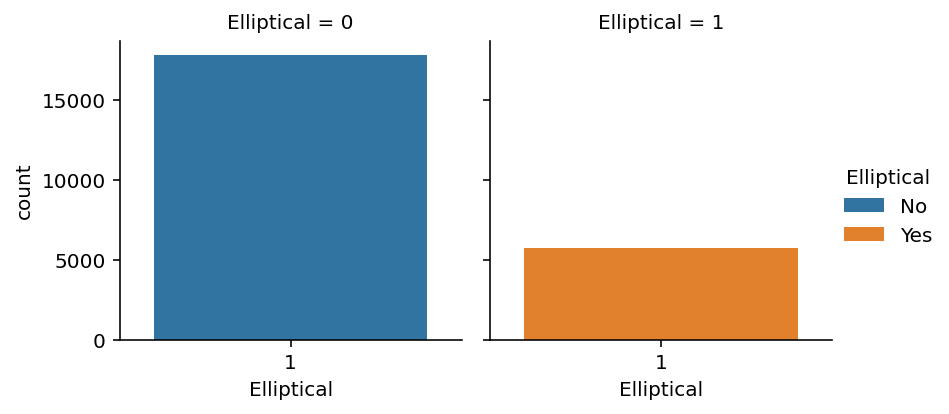

In [144]:
g = sns.FacetGrid(data, col="Elliptical", hue="Elliptical")
g.map(sns.countplot, "Elliptical")
g.add_legend(labels=["No", "Yes"])

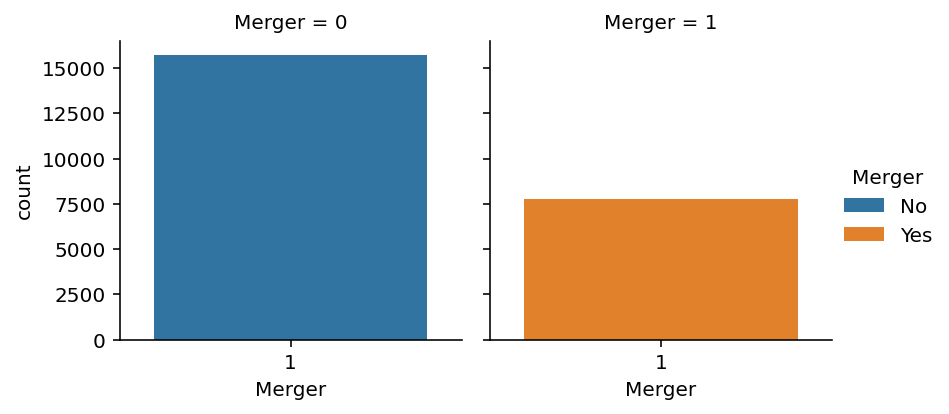

In [145]:
g = sns.FacetGrid(data, col="Merger", hue="Merger")
g.map(sns.countplot, "Merger")
g.add_legend(labels=["No", "Yes"])